In [ ]:
!pip install face_recognition

import os
import sys
import shutil
import random
from pathlib import Path
from shutil import copyfile
import glob
from tqdm import tqdm

from PIL import Image, ImageFile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import urllib.request

import face_recognition

     |████████████████████████████████| 100.1 MB 24 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=3b39803f870e3ec3019e2d63ab6459c386026b9e6714dcfe0466c8507388b547
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


**Global Variable Path**

In [ ]:
ROOT_DIR = os.path.join(os.path.dirname(os.path.abspath(os.curdir)),'content')
random.seed(61)

N_IMAGES_PER_IDENTITY = 10

# We need nose bridge and chin to fit on mask
KEY_FACIAL_FEATURES = {'nose_bridge', 'chin'}
MODEL = 'cnn'

tf.get_logger().setLevel('ERROR') #disable tf warning

DATA_DIR = Path(ROOT_DIR) / 'data'
VGGFACE2_DIR = Path(ROOT_DIR) / 'vggface2'

# Raw images will be used for validation and test set. Note that VGGFace2 images will be used for training. 
RAW_IMAGES_DIR = DATA_DIR / 'raw_images'

In [ ]:
PREDICTION_PLOT_DIR = DATA_DIR / 'overall_model_evaluation' / 'predictions'
PLOT_DIR_CORRECT = PREDICTION_PLOT_DIR / 'all_correct'
PLOT_DIR_CORRECT.mkdir(exist_ok = True, parents = True)
PLOT_DIR_MISTAKE = PREDICTION_PLOT_DIR / 'mistake'
PLOT_DIR_MISTAKE.mkdir(exist_ok = True, parents = True)

In [ ]:
VGGFACE2_DIR

PosixPath('/content/vggface2')

In [ ]:
PREDICTION_PLOT_DIR

PosixPath('/content/data/overall_model_evaluation/predictions')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/face_reconigition_mask/archive.zip" -d "/content/vggface2"

In [ ]:
! unzip "/content/drive/MyDrive/face_reconigition_mask/mask-templates.zip" -d "/content/data"

In [ ]:
# Find identity directories in test folder
identity_dirs = [x for x in VGGFACE2_DIR.iterdir() if x.is_dir()]

# Create DATA directory if it does not exist
os.makedirs(DATA_DIR, exist_ok=True)

# Create a directory to save sampled images if not created
sampled_image_dir = os.path.join(ROOT_DIR, 'data', 'sampled_face_images')
os.makedirs(sampled_image_dir, exist_ok=True)

In [ ]:
# Delete all images from sampled_face_images folder if already exists
images = glob.glob(os.path.join(sampled_image_dir, '*'))
for f in images:
    os.remove(f)

for identity_dir in identity_dirs:
    indentity_face_images = glob.glob(os.path.join(identity_dir, "*.jpg"))
    sampled_image_dirs = random.sample(indentity_face_images, N_IMAGES_PER_IDENTITY)
    identity_name = os.path.basename(identity_dir)

    for src_dir in sampled_image_dirs:
        face_image_fname = os.path.basename(src_dir)
        dst_dir =  os.path.join(sampled_image_dir, identity_name + '_' + face_image_fname)
        copyfile(src_dir,dst_dir)

**Prepair Trainset**

In [ ]:
def create_masked_face(image_path, mask_path, crop_face=True):
    # Convert image into a format that face_recognition library understands
    face_image_np = face_recognition.load_image_file(image_path)
    
    # Recognize face boundaries from an image 
    face_locations = face_recognition.face_locations(face_image_np, model=MODEL)
    
    # Find facial landmarks from the recognized face to fit mask
    face_landmarks = face_recognition.face_landmarks(face_image_np, face_locations)
    has_key_face_landmarks = check_face_landmarks(face_landmarks)
    
    if has_key_face_landmarks:
        face_img = Image.fromarray(face_image_np)
        mask_img = Image.open(mask_path)
        face_mask_img = mask_face(face_img, mask_img, face_landmarks[0])
        if crop_face:
            return crop_image(face_mask_img, face_locations[0])
        else: 
            return face_mask_img
    else:
        return None

def check_face_landmarks(face_landmarks):
    # Check whether there is a face_landmark
    if len(face_landmarks) > 0:
        # Check face_landmarks include all key facial features to fit mask
        if face_landmarks[0].keys() >= KEY_FACIAL_FEATURES:
            return True
        else:
            return False
    else:
        return False

def mask_face(face_img, mask_img, face_landmark):
    nose_bridge = face_landmark['nose_bridge']
    nose_point = nose_bridge[len(nose_bridge) * 1 // 4]
    nose_v = np.array(nose_point)

    chin = face_landmark['chin']
    chin_len = len(chin)
    chin_bottom_point = chin[chin_len // 2]
    chin_bottom_v = np.array(chin_bottom_point)
    chin_left_point = chin[chin_len // 8]
    chin_right_point = chin[chin_len * 7 // 8]

    # split mask and resize
    width = mask_img.width
    height = mask_img.height
    width_ratio = 1.2
    new_height = int(np.linalg.norm(nose_v - chin_bottom_v))

    # left
    mask_left_img = mask_img.crop((0, 0, width // 2, height))
    mask_left_width = get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)
    mask_left_width = int(mask_left_width * width_ratio)
    mask_left_img = mask_left_img.resize((mask_left_width, new_height))

    # right
    mask_right_img = mask_img.crop((width // 2, 0, width, height))
    mask_right_width = get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)
    mask_right_width = int(mask_right_width * width_ratio)
    mask_right_img = mask_right_img.resize((mask_right_width, new_height))

    # merge mask
    size = (mask_left_img.width + mask_right_img.width, new_height)
    mask_img = Image.new('RGBA', size)
    mask_img.paste(mask_left_img, (0, 0), mask_left_img)
    mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

    # rotate mask
    angle = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
    rotated_mask_img = mask_img.rotate(angle, expand=True)

    # calculate mask location
    center_x = (nose_point[0] + chin_bottom_point[0]) // 2
    center_y = (nose_point[1] + chin_bottom_point[1]) // 2

    offset = mask_img.width // 2 - mask_left_img.width
    radian = angle * np.pi / 180
    box_x = center_x + int(offset * np.cos(radian)) - rotated_mask_img.width // 2
    box_y = center_y + int(offset * np.sin(radian)) - rotated_mask_img.height // 2

    # add mask
    face_img.paste(mask_img, (box_x, box_y), mask_img)
    return face_img

def get_distance_from_point_to_line(point, line_point1, line_point2):
    distance = np.abs((line_point2[1] - line_point1[1]) * point[0] +
                      (line_point1[0] - line_point2[0]) * point[1] +
                      (line_point2[0] - line_point1[0]) * line_point1[1] +
                      (line_point1[1] - line_point2[1]) * line_point1[0]) / \
               np.sqrt((line_point2[1] - line_point1[1]) * (line_point2[1] - line_point1[1]) +
                       (line_point1[0] - line_point2[0]) * (line_point1[0] - line_point2[0]))
    return int(distance)

def save(save_dir, fname, face_img):
    dest_path = os.path.join(save_dir, fname)
    face_img.save(dest_path)
    
def crop_image(img, face_location):
    top, right, bottom, left = face_location
    return img.crop((left, top, right, bottom))

**Mask data sample**

100%|██████████| 2500/2500.0 [08:37<00:00,  4.83it/s]


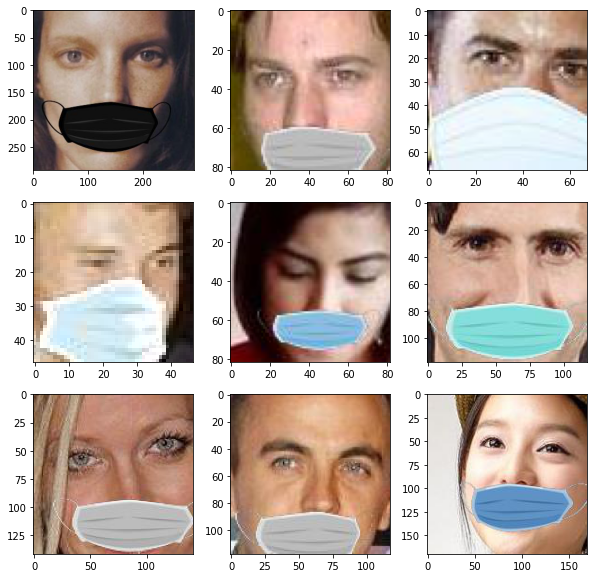

In [ ]:
# Get available masks in mask-templates dir
available_masks = glob.glob(os.path.join(ROOT_DIR, 'data', 'mask-templates', "*.png"))
available_sample_face_imgs = glob.glob(os.path.join(ROOT_DIR, 'data', 'sampled_face_images', "*.jpg"))
random.shuffle(available_sample_face_imgs)

# Half of the images will be masked and the other half will be not masked
target_n_masked_face_imgs = len(available_sample_face_imgs) / 2
n_masked_images = 0

# Create a directory to save masked / not masked images
train_dir = Path(DATA_DIR) / 'train'
masked_img_dir = train_dir / 'masked'
not_masked_img_dir = train_dir / 'not_masked'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(masked_img_dir, exist_ok=True)
os.makedirs(not_masked_img_dir, exist_ok=True)

# Delete all train data images if it already exists
images = glob.glob(os.path.join(masked_img_dir, '*.jpg'))
images += glob.glob(os.path.join(not_masked_img_dir, '*.jpg'))
for f in images:
    os.remove(f)
    
pbar = tqdm(total=target_n_masked_face_imgs)

# Add artificial mask to the detected faces until we reach half of the images in sampled_face_images directory
while len(available_sample_face_imgs) and n_masked_images < target_n_masked_face_imgs:
    image_path = available_sample_face_imgs.pop()
    fname  = os.path.basename(image_path)
    
    random_mask_path = random.choice(available_masks)
    masked_face = None
    try:
        masked_face = create_masked_face(image_path, random_mask_path)
    except:
        print('{} file is passed'.format(fname))
    if masked_face is not None:
        save(masked_img_dir, fname, masked_face)
        n_masked_images += 1
        pbar.update(1)
pbar.close()

# Plot some examples
ex_artif_masked_face_dirs = random.sample(glob.glob(os.path.join(masked_img_dir, '*.jpg')), 9)
fig = plt.figure(figsize=(10, 10))
for idx, artif_masked_face_dir in enumerate(ex_artif_masked_face_dirs):
    pil_im =  Image.open(artif_masked_face_dir)
    im_array = np.asarray(pil_im)
    fig.add_subplot(3, 3, idx + 1)
    plt.imshow(im_array)
plt.show()

**Not mask data sample**

100%|██████████| 2477/2477 [05:20<00:00,  7.73it/s]


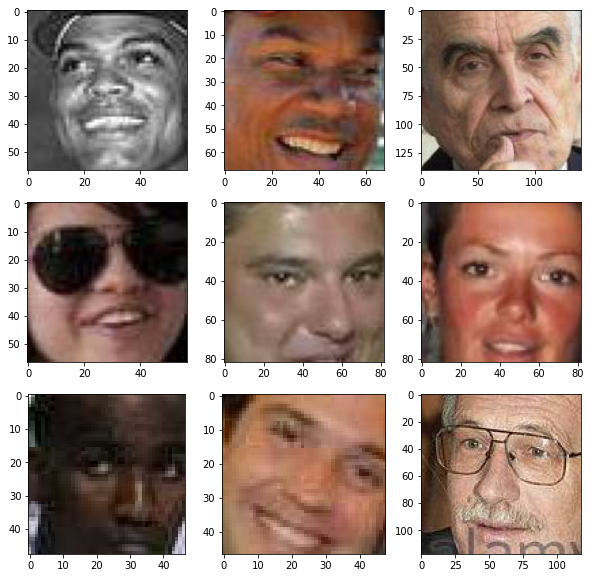

In [ ]:
for remaining_img_path in tqdm(available_sample_face_imgs):
    # Convert image into format that face_recognition library understands 
    face_image_np = face_recognition.load_image_file(remaining_img_path)
    
    # Recognize face boundaries from an image 
    face_locations = face_recognition.face_locations(face_image_np, model=MODEL)

    img = Image.open(remaining_img_path)
    if len(face_locations) > 0:
        cropped_img = crop_image(img, face_locations[0])
        fname = os.path.basename(remaining_img_path)
        save(not_masked_img_dir, fname, cropped_img)
        
# Plot some examples
ex_not_masked_face_dirs = random.sample(glob.glob(os.path.join(not_masked_img_dir, '*.jpg')), 9)
fig = plt.figure(figsize=(10, 10))
for idx, not_masked_face_dir in enumerate(ex_not_masked_face_dirs):
    pil_im = Image.open(not_masked_face_dir)
    im_array = np.asarray(pil_im)
    fig.add_subplot(3, 3, idx + 1)
    plt.imshow(im_array)
plt.show()

**Create Artificial validation dataset**

In [ ]:
artif_masked_val_dir = DATA_DIR / 'validation' / 'artificial' / 'masked'
artif_not_masked_val_dir = DATA_DIR / 'validation' / 'artificial' / 'not_masked'

# Create DATA directory if it does not exist
os.makedirs(artif_masked_val_dir, exist_ok=True)
os.makedirs(artif_not_masked_val_dir, exist_ok=True)

sample_ratio = 0.2

# Move 20% of the random masked faces data from train to validation
train_masked_imgs = glob.glob(str(DATA_DIR / 'train' / 'masked' / '*.jpg'))
sample_train_masked_imgs = random.sample(train_masked_imgs, int(sample_ratio * len(train_masked_imgs)))
for src_img_dir in sample_train_masked_imgs:
    shutil.move(src_img_dir, artif_masked_val_dir / os.path.basename(src_img_dir))
    
# Move 20% of the random not masked faces data from train to validation
train_not_masked_imgs = glob.glob(str(DATA_DIR / 'train' / 'not_masked' / '*.jpg'))
sample_train_not_masked_imgs = random.sample(train_not_masked_imgs, int(sample_ratio * len(train_not_masked_imgs)))
for src_img_dir in sample_train_not_masked_imgs:
    shutil.move(src_img_dir, artif_not_masked_val_dir / os.path.basename(src_img_dir))

**Crate Real validation dataset**

In [ ]:
df_test_validation_metadata = pd.read_csv('/content/drive/MyDrive/face_reconigition_mask/test_validation_metadata.csv', index_col=None)
df_test_validation_metadata

,class,x,y,w,h,image_urls,raw_img_dir,cropped_img_dir
0,masked,549,319,253,301,https://images.unsplash.com/photo-158009468719...,data/raw_images/0.jpg,data/validation/real/masked/0.jpg
1,masked,171,164,170,189,https://images.unsplash.com/photo-153000644495...,data/raw_images/1.jpg,data/test/masked/1.jpg
2,masked,253,94,90,110,https://images.unsplash.com/photo-158430983231...,data/raw_images/2.jpg,data/test/masked/2.jpg
3,masked,171,255,129,182,https://images.unsplash.com/photo-151247906453...,data/raw_images/3.jpg,data/test/masked/3.jpg
4,masked,68,92,118,135,https://images.unsplash.com/photo-158452176459...,data/raw_images/4.jpg,data/validation/real/masked/4.jpg
...,...,...,...,...,...,...,...,...
518,not_masked,241,99,29,52,https://images.unsplash.com/photo-1551434678-e...,data/raw_images/271.jpg,data/test/not_masked/519.jpg
519,not_masked,337,55,58,94,https://images.unsplash.com/photo-1551434678-e...,data/raw_images/271.jpg,data/test/not_masked/520.jpg
520,not_masked,303,116,24,32,https://images.unsplash.com/photo-1556761175-b...,data/raw_images/272.jpg,data/validation/real/not_masked/521.jpg
521,not_masked,403,144,31,44,https://images.unsplash.com/photo-1556761175-b...,data/raw_images/272.jpg,data/validation/real/not_masked/522.jpg


In [ ]:
opener=urllib.request.build_opener()
# the opener is needed to avoid 403 from pexels
opener.addheaders=[('User-Agent', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
urllib.request.install_opener(opener)

# Get raw image URLs
image_urls = df_test_validation_metadata['image_urls'].tolist()

# Get raw image directories
raw_img_dirs = df_test_validation_metadata['raw_img_dir'].tolist()

# Create a raw image folder if does not exist
os.makedirs(os.path.join(ROOT_DIR, os.path.dirname(raw_img_dirs[0])), exist_ok=True)

# Delete all raw data images if it already exists
images = glob.glob(os.path.join(ROOT_DIR, os.path.dirname(raw_img_dirs[0]), '*.jpg'))
for f in images:
    os.remove(f)
    
# Iterate over raw image URLs and download raw images to the specified folder
for idx, img_url in enumerate(image_urls):
    try:
        urllib.request.urlretrieve(img_url, os.path.join(ROOT_DIR, raw_img_dirs[idx]))
    except:
        print('skipping {}'.format('img_url'))
print('All raw images are downloaded to {}'.format(os.path.dirname(raw_img_dirs[0])))

skipping img_url
skipping img_url
skipping img_url
skipping img_url
skipping img_url
skipping img_url
skipping img_url
skipping img_url
skipping img_url
All raw images are downloaded to data/raw_images


**Prepare real validation dataset**

In [ ]:
real_masked_val_dir = DATA_DIR / 'validation' / 'real' / 'masked'
real_not_masked_val_dir = DATA_DIR / 'validation' / 'real' / 'not_masked'

# Create directories if cropped directory does not exist 
os.makedirs(str(real_masked_val_dir), exist_ok=True)
os.makedirs(str(real_not_masked_val_dir), exist_ok=True)

# Delete all real validation set images if it already exists
images = glob.glob(os.path.join(str(real_masked_val_dir), '*.jpg'))
images += glob.glob(os.path.join(str(real_not_masked_val_dir), '*.jpg'))
for f in images:
    os.remove(f)

In [ ]:
df_validation_dir = df_test_validation_metadata[df_test_validation_metadata['cropped_img_dir'].
                                                str.contains('data/validation/')]
df_validation_dir
for idx, row in df_validation_dir.iterrows():
    img_raw_path = row['raw_img_dir']
    try:
      img = Image.open(os.path.join(ROOT_DIR, img_raw_path))
    except:
       continue
    img = img.crop((row['x'], row['y'], row['x'] + row['w'], row['y'] + row['h']))
    try:
        img.save(os.path.join(ROOT_DIR, row['cropped_img_dir']))
    except:
        print('skipping {} img'.format(row['image_urls']))

**Prepare real test dataset**

In [ ]:
real_masked_val_dir = DATA_DIR / 'test' / 'masked'
real_not_masked_val_dir = DATA_DIR / 'test' / 'not_masked'

# Create directories if cropped directory does not exist 
os.makedirs(str(real_masked_val_dir), exist_ok=True)
os.makedirs(str(real_not_masked_val_dir), exist_ok=True)

# Delete all real validation set images if it already exists
images = glob.glob(os.path.join(str(real_masked_val_dir), '*.jpg'))
images += glob.glob(os.path.join(str(real_not_masked_val_dir), '*.jpg'))
for f in images:
    os.remove(f)

In [ ]:
df_test_dir = df_test_validation_metadata[df_test_validation_metadata['cropped_img_dir'].
                                                str.contains('data/test/')]

for idx, row in df_test_dir.iterrows():
    img_raw_path = row['raw_img_dir']
    try:
      img = Image.open(os.path.join(ROOT_DIR, img_raw_path))
    except:
      continue
    img = img.crop((row['x'], row['y'], row['x'] + row['w'], row['y'] + row['h']))
    try:
        img.save(os.path.join(ROOT_DIR, row['cropped_img_dir']))
    except:
        print('skipping {} img'.format(row['image_urls']))

skipping https://cdn.pixabay.com/photo/2020/03/27/23/49/doctor-4975298_960_720.png img


#Train mask classification

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import os
import cv2

from sklearn import metrics 
from pathlib import Path

**Setup Parameter**

In [ ]:
target_size = (112,112)
batch_size = 32
lr = 0.01
n_epochs = 2 

root_dir = os.path.dirname(os.path.join(os.path.abspath(os.curdir),'content'))
data_dir = Path(root_dir) / 'data'

model_dir = data_dir / 'classifier_model_weights'
model_dir.mkdir(exist_ok=True)

performance_plots_dir = Path('img')
performance_plots_dir.mkdir(exist_ok=True)

**Create data generator (Augumentation)**

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(str(data_dir / 'train'),
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=['not_masked', 'masked'],
                                                    shuffle=True)

Found 3959 images belonging to 2 classes.


In [ ]:
val_datagen_artificial = ImageDataGenerator(preprocessing_function=preprocess_input,rescale = 1./255)
val_generator_artificial = val_datagen_artificial.flow_from_directory(str(data_dir / 'validation' / 'artificial'),
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=['not_masked', 'masked'],
                                                    shuffle=False)

Found 989 images belonging to 2 classes.


In [ ]:
val_datagen_real = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator_real = val_datagen_real.flow_from_directory(str(data_dir / 'validation' / 'real'),
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=['not_masked', 'masked'],
                                                    shuffle=False)

Found 261 images belonging to 2 classes.


**Define Model**

In [ ]:
base_model = MobileNet(weights='imagenet',include_top=False, input_shape=(target_size[0],target_size[1],3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation = "relu")(x)
preds = Dense(1,activation = "sigmoid")(x)

model = Model(inputs = base_model.input, outputs = preds)
for layer in model.layers[:-4]:
    print(layer)
    layer.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
class SubsetAccuracy(tf.keras.callbacks.Callback):
    """
    We want to monitor accuracy in the validation set separately for real and artificial face masks.
    This callback will print this to the output, and store the values for each epoch.
    
    It also stores the best model (according to validation accuracy on the masked faces) to disk.
    """
    
    def __init__(self, real_val_gen=None):
        self.real_val_gen = real_val_gen
        self.cur_best_acc = 0
        
    def on_epoch_end(self, batch, logs={}):
        pred = self.model.predict(self.real_val_gen)
        bin_pred = [x > 0.5 for x in pred]
        real_acc = metrics.accuracy_score(self.real_val_gen.classes, bin_pred)
        
        print(f"Accuracy on the real validation set: {real_acc:.2f}")
        
        if real_acc > self.cur_best_acc:
            self.model.save(model_dir / 'best.h5')
            self.cur_best_acc = real_acc
          
subset_acc = SubsetAccuracy(val_generator_real)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size
step_size_val = val_generator_artificial.n//val_generator_artificial.batch_size

model.fit_generator(generator=train_generator, 
                    steps_per_epoch=step_size_train, 
                    epochs=2, 
                    validation_data=val_generator_artificial, 
                    validation_steps=step_size_val, 
                    callbacks=[subset_acc])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/2
123/123 [==============================] - 20s 63ms/step - loss: 0.1509 - accuracy: 0.9829 - val_loss: 1.0843 - val_accuracy: 0.5094
Epoch 2/2
123/123 [==============================] - 5s 42ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.1520 - val_accuracy: 0.5094


#Get bet model

In [ ]:
best_model = tf.keras.models.load_model(model_dir / 'best.h5')

In [ ]:
val_pred = best_model.predict(val_generator_real)

In [ ]:
val_pred_bin = [x[0] > 0.5 for x in val_pred]

acc = metrics.accuracy_score(val_generator_real.classes, val_pred_bin)
print(f"Accuracy = {acc:.3f}")

Accuracy = 0.920


**Plot confusion matrix**

In [ ]:
def plot_confusion_matrix(cm,classes,normalize = False,
                          title = 'Confusion matrix',cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

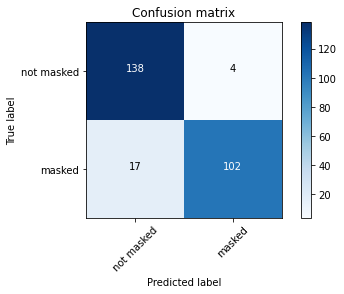

In [ ]:
cm = metrics.confusion_matrix(val_generator_real.classes, val_pred_bin)
plt.figure()
plot_confusion_matrix(cm, ['not masked', 'masked'])
plt.savefig(performance_plots_dir / 'confusion.png', bbox_inches='tight', pad_inches=0)


**Plotting the mistakes**

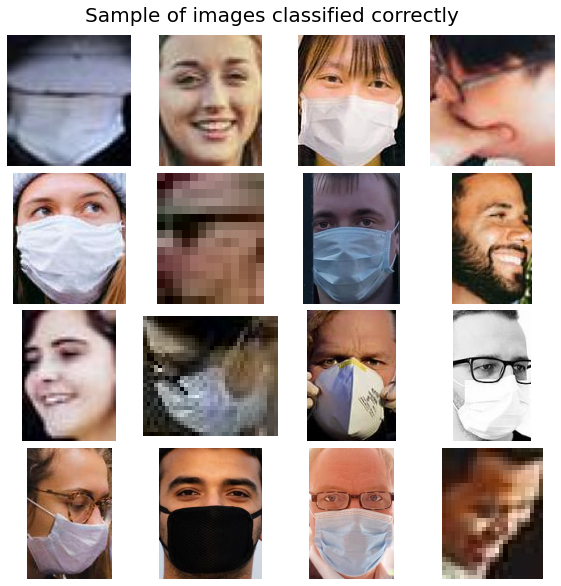

In [ ]:
n_to_plot = 16

mistakes = []
correct = []
for fn, true_label, pred_label in zip(val_generator_real.filenames, val_generator_real.classes, val_pred_bin):
    if true_label != pred_label:
        mistakes.append(data_dir / 'validation' / 'real'/ fn)
    else: 
        correct.append(data_dir / 'validation' / 'real'/ fn)
        
nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

to_plot = random.sample(correct,n_to_plot)
plt.figure(figsize=(10,10))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images classified correctly', size=20, y=0.92)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

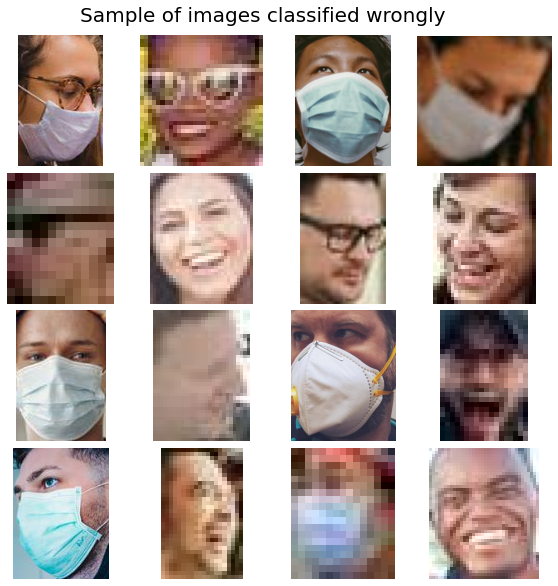

In [ ]:
to_plot = random.sample(correct,n_to_plot)
plt.figure(figsize=(10,10))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images classified wrongly', size=20, y=0.92)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [ ]:
!pip install face_detection
import face_detection
import urllib.request

  Created wheel for face-detection: filename=face_detection-0.2.2-py3-none-any.whl size=25574 sha256=ccdd8e5b8731363a6a113fed8a7c774582429d7e16fb473496bf7b5686ff3cab
  Stored in directory: /root/.cache/pip/wheels/dd/2d/84/c7a9ce1760b00f8b1d431c9564b108acfb98f588c18d4a1a9c
Successfully built face-detection


**RETAIN_FACE**

In [ ]:
root_dir = os.path.dirname(os.path.join(os.path.abspath(os.curdir),'content'))
data_dir = Path(root_dir) / 'data'
raw_images_dir = Path(data_dir) / 'raw_images'

#this file containt ground_truth to compare
ground_truth_annotations_fn = data_dir / 'test_validation_metadata.csv'

#outputl file -> evaluate
detector_bbox_annotations_fn = data_dir / 'detector_annotations.csv'

#this are the cropped
detector_crop_output = data_dir / 'overall_model_evaluation' / 'detector_crops'
detector_crop_output.mkdir(exist_ok = True, parents = True)

# this will be used to store the results of the detector, and to plot some of these at the end of this notebook
detector_result_dir = data_dir / 'overall_model_evaluation' / 'detector_results'
detector_result_dir.mkdir(exist_ok=True, parents=True)

**Get crawl data**

In [ ]:
df_test_validation_metadata = pd.read_csv('/content/drive/MyDrive/face_reconigition_mask/test_validation_metadata.csv', index_col=None)
df_test_validation_metadata

,class,x,y,w,h,image_urls,raw_img_dir,cropped_img_dir
0,masked,549,319,253,301,https://images.unsplash.com/photo-158009468719...,data/raw_images/0.jpg,data/validation/real/masked/0.jpg
1,masked,171,164,170,189,https://images.unsplash.com/photo-153000644495...,data/raw_images/1.jpg,data/test/masked/1.jpg
2,masked,253,94,90,110,https://images.unsplash.com/photo-158430983231...,data/raw_images/2.jpg,data/test/masked/2.jpg
3,masked,171,255,129,182,https://images.unsplash.com/photo-151247906453...,data/raw_images/3.jpg,data/test/masked/3.jpg
4,masked,68,92,118,135,https://images.unsplash.com/photo-158452176459...,data/raw_images/4.jpg,data/validation/real/masked/4.jpg
...,...,...,...,...,...,...,...,...
518,not_masked,241,99,29,52,https://images.unsplash.com/photo-1551434678-e...,data/raw_images/271.jpg,data/test/not_masked/519.jpg
519,not_masked,337,55,58,94,https://images.unsplash.com/photo-1551434678-e...,data/raw_images/271.jpg,data/test/not_masked/520.jpg
520,not_masked,303,116,24,32,https://images.unsplash.com/photo-1556761175-b...,data/raw_images/272.jpg,data/validation/real/not_masked/521.jpg
521,not_masked,403,144,31,44,https://images.unsplash.com/photo-1556761175-b...,data/raw_images/272.jpg,data/validation/real/not_masked/522.jpg


In [ ]:
def bb_intersection_over_union(boxA,boxB):

    xA = max(boxA[0],boxB[0])
    yA = max(boxA[1],boxB[1])
    xB = min(boxA[2],boxB[2])
    yB = min(boxA[3],boxB[3])

    interArea = max(0,(1 + xB - xA)) * max((1 + yB - yA),0)
    boxA_area = (boxA[0] - boxA[2] + 1) * (boxA[1] - boxA[3] + 1)
    boxB_area = (boxB[0] - boxB[2] + 1) * (boxB[1] - boxB[3] + 1)

    iou = interArea / (boxA_area + boxB_area - interArea)

    return iou

In [ ]:
tf.keras.backend.clear_session()

**Setup**

In [ ]:
tf.keras.backend.clear_session()
detector = face_detection.build_detector("RetinaNetMobileNetV1", confidence_threshold=.5, nms_iou_threshold=.3)

In [ ]:
detector_bbox = pd.DataFrame(columns=['img','bbox_id','x','y','w','h','crop_fn'])
real_raw_img = list(sorted(raw_images_dir.glob('*.jpg')))

for idx, fn in enumerate(real_raw_img):

    img = cv2.imread(str(fn))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    try:
      detections = detector.detect(img)
    except:
      continue

    for row_index in range(detections.shape[0]):
        ann = detections[row_index]
        x1 = int(ann[0])
        y1 = int(ann[1])
        x2 = int(ann[2])
        y2 = int(ann[3])

        cropped_face = img[y1 : y2, x1 : x2]

        if cropped_face.shape[0] == 0 or cropped_face.shape[1] == 0:
          print(f"Detector extracted a face with 0 rows or columns, skipping this one for {fn}")
          continue

        output_fn = detector_crop_output / (fn.stem + '_' + str(row_index) + '.jpg')
        cv2.imwrite(str(output_fn), cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))     
        
        detector_bbox.loc[len(detector_bbox)] = [fn.name,row_index,x1,y1,x2-x1,y2-y1, str(output_fn)]


In [ ]:
ground_truth = pd.read_csv(ground_truth_annotations_fn)
ground_truth['img_name'] = ground_truth.raw_img_dir.apply(lambda x: Path(x).name)

fn_to_gt_boxes = dict()
fn_to_detector_boxes = dict()

for idx, img_fn in enumerate(real_raw_img):

    img = cv2.imread(str(img_fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(img/255)
    
    ground_truth_fn = ground_truth[ground_truth.img_name == img_fn.name]
    gt_boxes = []
    for row_idx in range(ground_truth_fn.shape[0]):
        ground_truth_annotation = ground_truth_fn.iloc[row_idx]
        x = ground_truth_annotation.x.item()
        y = ground_truth_annotation.y.item()
        w = ground_truth_annotation.w.item()
        h = ground_truth_annotation.h.item()
        gt_boxes.append((x,y,x+w,y+h))
        rect = plt.Rectangle((x,y),w,h,linewidth=3,edgecolor='green',facecolor='none')
        plt.gca().add_patch(rect)
    fn_to_gt_boxes[img_fn] = gt_boxes
    
    bbox_fn = detector_bbox[detector_bbox.img == img_fn.name]
    pred_boxes = []
    for row_idx in range(bbox_fn.shape[0]):
        pred_annotation = bbox_fn.iloc[row_idx]
        x = pred_annotation.x
        y = pred_annotation.y
        w = pred_annotation.w
        h = pred_annotation.h
        pred_boxes.append((x,y,x+w,y+h))
        rect = plt.Rectangle((x,y),w,h,linewidth=3,edgecolor='red',facecolor='none')
        plt.gca().add_patch(rect)
    fn_to_detector_boxes[img_fn] = pred_boxes
    
    plt.axis('off')
    plt.savefig(detector_result_dir / img_fn.name, bbox_inches='tight', pad_inches=0)
    plt.close()

In [ ]:
tp = 0
fp = 0
fn = 0

correct = []
mistakes = []
    
for idx, img_fn in enumerate(real_raw_img):
    pred_boxes = fn_to_detector_boxes[img_fn]
    gt_boxes = fn_to_gt_boxes[img_fn]
    
    # we have to keep track of previous fn and fp to see if there was a mistake
    # in this particular image
    fn_prev = fn
    fp_prev = fp
    
    # first we check for each ground truth bounding box whether it was detected
    for gt_box in gt_boxes:
        times_found = 0
        for pred_box in pred_boxes: 
            iou = bb_intersection_over_union(gt_box, pred_box)
            if iou >= 0.5:
                times_found += 1
        
        if times_found > 0:
            # the face was detected at least once, so it is a true positive
            tp += 1
        
            # if it is detected more than once, we add the duplicate detections to the false positives
            n_duplicates = times_found - 1
            if n_duplicates > 0:
                fp += n_duplicates
        
        if times_found == 0:
            fn += 1
        
    # we also have to check for detected bounding boxes that do not overlap with any ground truth bounding box,
    # as these are counted as false negatives
    for pred_box in pred_boxes:
        found = False
        for gt_box in gt_boxes:
            iou = bb_intersection_over_union(gt_box, pred_box)
            if iou > 0.5:
                found = True
                break
        if not found:
            fp += 1
            
    if fn_prev != fn or fp_prev != fp:
        mistakes.append(detector_result_dir / img_fn.name)
    else:
        correct.append(detector_result_dir / img_fn.name)

In [ ]:
print(f"Number of true positives: {tp}")
print(f"Number of false positives: {fp}")
print(f"Number of false negatives: {fn}")

**Plot some mistake and correct data**

In [ ]:
n_to_plot = 16
to_plot = random.sample(correct,n_to_plot)

nrow = 4
ncol = 4

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with all faces detected correctly', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [ ]:
n_to_plot = 16
to_plot = random.sample(mistakes,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with mistakes in face detection', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

**Evaluation code**